### Data Cleaning Notebook: For a dataset with zipcode as rows, we did dummied the ratings and Price.
### For the categories I used countvectorizer to assign the matrix to the original data set.
### As the Countvecrizer does not perform well, I saved the data with two copies, one with countvecrizer one without

In [275]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.cluster import KMeans

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin


import pickle
import folium

In [2]:
df= pd.read_csv('../data/03_data_income.csv')
df.head()

,id,latitude,longitude,price,review_count,rating,zip_code,city,alias,category,med_agi,avg_agi,count
0,zzvkb4J_sQAk8N20OWdZhg,33.911154,-117.881259,2,1257.0,3.5,92821,Brea,lucilles-smokehouse-bar-b-que-brea,"['bbq', 'smokehouse', 'southern']",86070,106163,170
1,zWs68lBY2PyNOTRJhxXapg,33.911959,-117.867374,1,22.0,3.0,92821,Brea,subway-restaurants-brea-4,['sandwiches'],86070,106163,170
2,zOYNwoDjpg6Ehwn0RKX9qA,33.911283,-117.867449,2,367.0,3.5,92821,Brea,nekter-juice-bar-brea,"['juicebars', 'acaibowls', 'icecream']",86070,106163,170
3,zNNLl821AlzApHYqRxNALw,33.911431,-117.865941,1,84.0,2.5,92821,Brea,arbys-brea-2,"['sandwiches', 'hotdogs']",86070,106163,170
4,zJ4pvxtpo3Y5LvylLXmCzA,33.932860,-117.916253,2,231.0,4.0,92821,Brea,portofino-trattoria-brea,['italian'],86070,106163,170


In [3]:
df['zip_code'] = df['zip_code'].astype(str)
df.dtypes

id               object
latitude        float64
longitude       float64
price             int64
review_count    float64
rating          float64
zip_code         object
city             object
alias            object
category         object
med_agi           int64
avg_agi           int64
count             int64
dtype: object

In [241]:
df_pivot = df.pivot_table(index='zip_code').reset_index()

In [242]:
df_pivot.to_csv('../data/data_zipcode_j.csv')

In [213]:
X = df.drop(columns=['avg_agi', 'med_agi', 'count', 'city', 'id', 'alias', 'zip_code'])
y = df['med_agi']
X.head()

,latitude,longitude,price,review_count,rating,category
0,33.911154,-117.881259,2,1257.0,3.5,"['bbq', 'smokehouse', 'southern']"
1,33.911959,-117.867374,1,22.0,3.0,['sandwiches']
2,33.911283,-117.867449,2,367.0,3.5,"['juicebars', 'acaibowls', 'icecream']"
3,33.911431,-117.865941,1,84.0,2.5,"['sandwiches', 'hotdogs']"
4,33.932860,-117.916253,2,231.0,4.0,['italian']


## Making custom transformers: Adjusted Price

Different types of businesses will have a different distribution of price ranges depending on the product or service they provide. For example, a taco shop with a price rating of '$$' is actually relatively expensive, whereas a sushi restaurant with the same rating is quite common. We hypothesize that a neighborhood with expensive taco shops might be more affluent than a neighborhood with average-priced sushi restaurants; more generally, neighborhoods with disproportionately expensive businessess might be more wealthy than those with just objectively expensive businesses.

In [82]:
print(df[df['category'].str.contains('tacos')]['price'].mean())
print(df[df['category'].str.contains('sushi')]['price'].mean())

1.2374581939799332
2.0346938775510206


We introduce the idea of an adjusted price, which has the goal of scaling a listing's price relative to the overall expensiveness of its parent category. We will calculate the adjusted price by looking at businesses category-by-category and standard scaling the listed price to the mean of that category.

Since we do not want to have any data leakage, we can only apply this transformation on our training data set. Therefore, it is inappropriate to engineer this feature at this stage.

In [95]:
oh = OneHotEncoder(categories='auto', sparse=False)
ohdata = oh.fit_transform(X[['rating']])
ohfeatures = oh.get_feature_names()
oh_df = pd.DataFrame(ohdata, columns=ohfeatures)
oh_df.head()

,x0_0.0,x0_1.0,x0_1.5,x0_2.0,x0_2.5,x0_3.0,x0_3.5,x0_4.0,x0_4.5,x0_5.0
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [90]:
X['rating']

0        3.5
1        3.0
2        3.5
3        2.5
4        4.0
        ... 
28107    4.0
28108    4.5
28109    4.0
28110    4.0
28111    4.5
Name: rating, Length: 28112, dtype: float64

In [152]:
# # https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65
# # https://www.slideshare.net/PyData/julie-michelman-pandas-pipelines-and-custom-transformers
# # https://gist.github.com/tdpetrou/6a97304dd4452a53be98e4f4e93196e6
# # https://stackoverflow.com/questions/44408861/

# class CategoryPricerReviewer(BaseEstimator, TransformerMixin):
    
#     def __init__(self):
#         self.pcv = None
#         self.rcv = None
        
#     def fit(self, X, y=None):
#         self.pcv = CountVectorizer().fit(X['category'])
#         self.rcv = CountVectorizer().fit(X['category'])
#         return self
            
#     def transform(self, X, y=None):     
        
#         catpri_cols = ['cat_pri_' + s for s in self.pcv.get_feature_names()]
#         catrat_cols = ['cat_rat_' + s for s in self.rcv.get_feature_names()]
        
#         C = self.pcv.transform(X['category']).toarray()
#         D = self.rcv.transform(X['category']).toarray()
        
#         for i in range(len(C)):
#             C[i] = C[i] * X['price'].values[i]
            
#         for j in range(len(D)):
#             D[j] = D[j] * X['rating'].values[j]
        
#         Cdf = pd.DataFrame(C, columns=catpri_cols, index=X.index)
#         Cdf.replace(0, np.NaN, inplace=True)
        
#         Ddf = pd.DataFrame(D, columns=catrat_cols, index=X.index)
#         Ddf.replace(0, np.NaN, inplace=True)
        
#         X = X.join(Cdf)
#         X = X.join(Ddf)
        
#         return X

In [185]:
class StandardizerAndCategoryReducer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.sc = None
        
    def fit(self, X, y=None):
        num_cols = [col for col in X.describe().columns if 'cluster' not in col]
        self.sc = StandardScaler().fit(X[num_cols])
        return self
            
    def transform(self, X, y=None):
        num_cols = [col for col in X.describe().columns if 'cluster' not in col]
        cat_cols = [col for col in X.columns if X[col].dtype == 'O']
        cluster_cols = [col for col in X.columns if 'cluster' in col]
        
        S = self.sc.transform(X[num_cols])
        Sdf = pd.DataFrame(S, columns=num_cols, index=X.index)
        catpri_cols = [col for col in X.columns if 'cat_pri_' in col]
        catrat_cols = [col for col in X.columns if 'cat_rat_' in col]
        
        Sdf.loc[:, 'price_adj'] = Sdf.loc[:, catpri_cols].mean(axis=1)
        Sdf.loc[:, 'rating_adj'] = Sdf.loc[:, catrat_cols].mean(axis=1)
        Sdf.drop(columns=catpri_cols + catrat_cols, inplace=True)
        
        X = X.loc[:, cat_cols + cluster_cols].join(Sdf)
        X.drop(columns='category', inplace=True)
        
        return X

In [195]:
# https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65
# https://www.slideshare.net/PyData/julie-michelman-pandas-pipelines-and-custom-transformers
# https://gist.github.com/tdpetrou/6a97304dd4452a53be98e4f4e93196e6
# https://stackoverflow.com/questions/44408861/

class CategoryPricer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.pcv = None
        
    def fit(self, X, y=None):
        self.pcv = CountVectorizer().fit(X['category'])
        return self
            
    def transform(self, X, y=None):     
        
        catpri_cols = ['cat_pri_' + s for s in self.pcv.get_feature_names()]
        
        C = self.pcv.transform(X['category']).toarray()
        
        for i in range(len(C)):
            C[i] = C[i] * X['price'].values[i]
        
        Cdf = pd.DataFrame(C, columns=catpri_cols, index=X.index)
        Cdf.replace(0, np.NaN, inplace=True)
        
        X = X.join(Cdf)
        
        return X

In [196]:
class StandardizerAndCategoryReducer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.sc = None
        
    def fit(self, X, y=None):
        num_cols = [col for col in X.describe().columns if 'cluster' not in col]
        self.sc = StandardScaler().fit(X[num_cols])
        return self
            
    def transform(self, X, y=None):
        num_cols = [col for col in X.describe().columns if 'cluster' not in col]
        cat_cols = [col for col in X.columns if X[col].dtype == 'O']
        cluster_cols = [col for col in X.columns if 'cluster' in col]
        
        S = self.sc.transform(X[num_cols])
        Sdf = pd.DataFrame(S, columns=num_cols, index=X.index)
        catpri_cols = [col for col in X.columns if 'cat_pri_' in col]
        
        Sdf.loc[:, 'price_adj'] = Sdf.loc[:, catpri_cols].mean(axis=1)
        Sdf.drop(columns=catpri_cols, inplace=True)
        
        X = X.loc[:, cat_cols + cluster_cols].join(Sdf)
        X.drop(columns='category', inplace=True)
        
        return X

## Transfer learning: KMeans

## attempt at a pipeline

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=111)

In [215]:
preprocessor = Pipeline([
    ('catpri', CategoryPricer()),
    ('sacr', StandardizerAndCategoryReducer())
])
Z_train = preprocessor.fit_transform(X_train)
Z_train.head()

,latitude,longitude,price,review_count,rating,price_adj
11130,-0.158758,-0.083118,-0.834990,-0.579423,-3.186599,-0.960900
22783,-1.589489,0.595342,-0.834990,-0.364631,-0.724279,-0.602790
25724,-0.669540,0.825886,0.899315,-0.192797,1.122461,0.897473
1210,0.920793,-1.450279,0.899315,-0.381337,1.122461,0.875899
13717,-1.329370,-0.684204,0.899315,0.079273,1.122461,0.737111


In [212]:
Z_train.dtypes

zip_code         object
cluster_0         uint8
cluster_1         uint8
cluster_2         uint8
cluster_3         uint8
                 ...   
longitude       float64
price           float64
review_count    float64
rating          float64
price_adj       float64
Length: 307, dtype: object

In [216]:
Z_test = preprocessor.transform(X_test)
Z_test.isna().sum()

latitude        0
longitude       0
price           0
review_count    0
rating          0
price_adj       0
dtype: int64

In [190]:
Z_test[Z_test['rating_adj'].isna()]

,zip_code,latitude,longitude,price,review_count,rating,price_adj,rating_adj
24267,90019,0.004176,-0.430967,-0.83499,-0.58181,-4.417759,-0.761115,NaN


In [193]:
X_test[X_test.index == 24267]

,latitude,longitude,price,review_count,rating,zip_code,category
24267,34.048286,-118.330391,1,0.0,0.0,90019,"['coffee', 'grocery']"


## clustering

In [174]:
X.shape

(28112, 8)

In [175]:
y.shape

(28112,)

In [197]:
def transfer_tune(X, y, k):
    
    # get location data from un-pivoted dataframe
    location_data = X[["latitude", "longitude"]]
    
    # instantiate KMeans
    km = KMeans(n_clusters=k)
    
    # fit
    km.fit(location_data)
    
    # insert 'cluster' column with predicted cluster based on k
    X.loc[:, 'cluster'] = km.predict(location_data)
    
    # create dummy columns for cluster
    X_dummy = pd.get_dummies(columns=['cluster'], data=X)
    
    # train-test split on new dummy dataframe
    X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=111, test_size=0.3
    )
    
    prep = Pipeline([
        ('catpri', CategoryPricer()),
        ('sacr', StandardizerAndCategoryReducer())
    ])
    
    Z_train = prep.fit_transform(X_train)
    Z_test = prep.transform(X_test)
    
    model = LinearRegression()
    model.fit(Z_train, y_train)
    r2 = model.score(Z_test, y_test)
    print(r2)
    # print score vs. k
    return r2

In [177]:
def transfer_tune_iterator(X, y, somelist):
    
    k_dict = dict()
    
    for k in somelist:
        r2 = transfer_tune(X, y, k)
        k_dict[str(k)] = r2
        
    k_df = pd.DataFrame(k_dict, index = [0]).T
    
    return k_df.sort_values(by=0, ascending=False)

## just going to see if i can make anything right now

In [204]:
df.head()

,id,latitude,longitude,price,review_count,rating,zip_code,city,alias,category,med_agi,avg_agi,count
0,zzvkb4J_sQAk8N20OWdZhg,33.911154,-117.881259,2,1257.0,3.5,92821,Brea,lucilles-smokehouse-bar-b-que-brea,"['bbq', 'smokehouse', 'southern']",86070,106163,170
1,zWs68lBY2PyNOTRJhxXapg,33.911959,-117.867374,1,22.0,3.0,92821,Brea,subway-restaurants-brea-4,['sandwiches'],86070,106163,170
2,zOYNwoDjpg6Ehwn0RKX9qA,33.911283,-117.867449,2,367.0,3.5,92821,Brea,nekter-juice-bar-brea,"['juicebars', 'acaibowls', 'icecream']",86070,106163,170
3,zNNLl821AlzApHYqRxNALw,33.911431,-117.865941,1,84.0,2.5,92821,Brea,arbys-brea-2,"['sandwiches', 'hotdogs']",86070,106163,170
4,zJ4pvxtpo3Y5LvylLXmCzA,33.932860,-117.916253,2,231.0,4.0,92821,Brea,portofino-trattoria-brea,['italian'],86070,106163,170


In [227]:
X = df.drop(columns=['avg_agi', 'med_agi', 'count', 'city', 'id', 'alias', 'zip_code', 'longitude', 'latitude'])
y = df['med_agi']
X.head()

,price,review_count,rating,category
0,2,1257.0,3.5,"['bbq', 'smokehouse', 'southern']"
1,1,22.0,3.0,['sandwiches']
2,2,367.0,3.5,"['juicebars', 'acaibowls', 'icecream']"
3,1,84.0,2.5,"['sandwiches', 'hotdogs']"
4,2,231.0,4.0,['italian']


In [228]:
location_data = df[["latitude", "longitude"]]
km = KMeans(n_clusters=300, random_state = 42)
km.fit(location_data)
X.loc[:, "cluster"] = km.predict(location_data)
X_dummy = pd.get_dummies(columns=["cluster"], data=X)
X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.3
)

prep = Pipeline([
    ('catpri', CategoryPricer()),
    ('sacr', StandardizerAndCategoryReducer())
])

Z_train = prep.fit_transform(X_train)
Z_test = prep.transform(X_test)

lr = LinearRegression()
lr.fit(Z_train, y_train)
r2 = lr.score(Z_test, y_test)
print (r2)

0.8106179302583403


In [232]:
pd.set_option('display.max_rows', 500)

In [234]:
list(Z_train.columns)

['cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster_5',
 'cluster_6',
 'cluster_7',
 'cluster_8',
 'cluster_9',
 'cluster_10',
 'cluster_11',
 'cluster_12',
 'cluster_13',
 'cluster_14',
 'cluster_15',
 'cluster_16',
 'cluster_17',
 'cluster_18',
 'cluster_19',
 'cluster_20',
 'cluster_21',
 'cluster_22',
 'cluster_23',
 'cluster_24',
 'cluster_25',
 'cluster_26',
 'cluster_27',
 'cluster_28',
 'cluster_29',
 'cluster_30',
 'cluster_31',
 'cluster_32',
 'cluster_33',
 'cluster_34',
 'cluster_35',
 'cluster_36',
 'cluster_37',
 'cluster_38',
 'cluster_39',
 'cluster_40',
 'cluster_41',
 'cluster_42',
 'cluster_43',
 'cluster_44',
 'cluster_45',
 'cluster_46',
 'cluster_47',
 'cluster_48',
 'cluster_49',
 'cluster_50',
 'cluster_51',
 'cluster_52',
 'cluster_53',
 'cluster_54',
 'cluster_55',
 'cluster_56',
 'cluster_57',
 'cluster_58',
 'cluster_59',
 'cluster_60',
 'cluster_61',
 'cluster_62',
 'cluster_63',
 'cluster_64',
 'cluster_65',
 'cluster_66',
 'clu

In [285]:
coef_dict = dict(zip(Z_train.columns, lr.coef_))
coef_df = pd.DataFrame(coef_dict.items(), columns=['feature', 'coef'])
coef_df

,feature,coef
0,cluster_0,-1.451395e+04
1,cluster_1,9.881589e+03
2,cluster_2,1.443229e+04
3,cluster_3,2.498729e+04
4,cluster_4,3.334031e+04
5,cluster_5,-3.135589e+04
6,cluster_6,-2.082674e+04
7,cluster_7,-4.083329e+04
8,cluster_8,-9.778760e+03
9,cluster_9,1.888815e+04


In [287]:
y_pred = lr.predict(Z_test)

In [289]:
residuals = y_test - y_pred

Text(0.5, 1.0, 'Residual Mean')

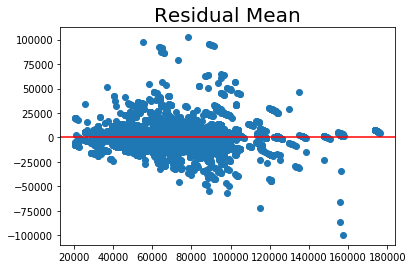

In [290]:
plt.scatter(y_pred, residuals)
plt.axhline(0, color='r')
plt.title('Residual Mean',size = 20)

In [238]:
pickle.dump(lr, open('../flask_app_complete/model_j.p', 'wb'))

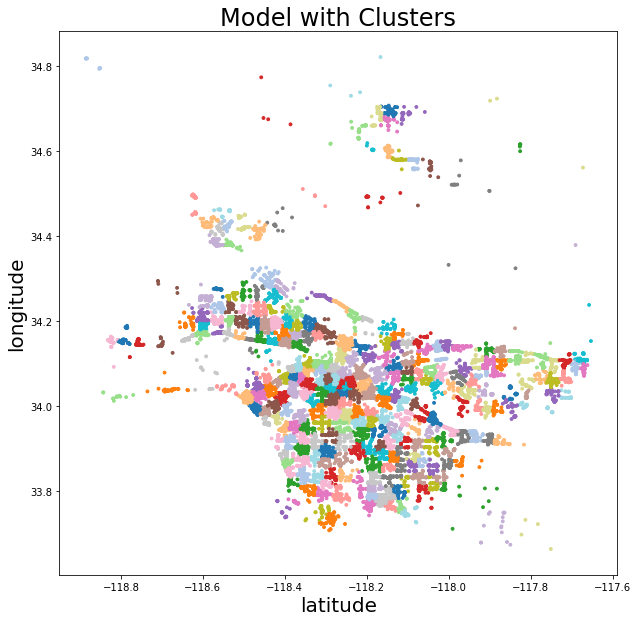

In [221]:
plt.figure(figsize=(10, 10))
plt.scatter(df.longitude, df.latitude, c=km.labels_, s=8, cmap="tab20")
plt.xlabel("latitude", fontsize = 20)
plt.ylabel("longitude", fontsize = 20)
plt.title('Model with Clusters', fontsize = 24);

In [307]:
Z_cluster = pd.concat([Z_train,Z_test],axis = 0, sort = False)
Z_cluster.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_294,cluster_295,cluster_296,cluster_297,cluster_298,cluster_299,price,review_count,rating,price_adj
18413,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.836631,-0.197074,-0.103384,-0.562599
14782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.836631,-0.165788,0.513285,-0.577336
9960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.889436,-0.283711,-1.336723,0.623610
3468,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.889436,0.828132,0.513285,0.413986
20005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.836631,-0.170601,0.513285,-1.288784


In [308]:
Z_cluster.sort_index()
Z_cluster.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_294,cluster_295,cluster_296,cluster_297,cluster_298,cluster_299,price,review_count,rating,price_adj
18413,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.836631,-0.197074,-0.103384,-0.562599
14782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.836631,-0.165788,0.513285,-0.577336
9960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.889436,-0.283711,-1.336723,0.623610
3468,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.889436,0.828132,0.513285,0.413986
20005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.836631,-0.170601,0.513285,-1.288784


In [309]:
Z_cluster = pd.concat([df['zip_code'], Z_cluster.sort_index()], axis=1)

In [310]:
Z_cluster['zip_code'] = Z_cluster['zip_code'].astype(int)

In [311]:
Z_cluster = Z_cluster.astype(float)

In [316]:
Z_cluster.pivot_table(index='zip_code')[Z_cluster.pivot_table(index='zip_code').index == 90012].values

array([[0.        , 0.        , 0.        , 0.        , 0.8427673 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00314465, 0.00314465, 0.        ,
        0.        , 0.03144654, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00314465, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [314]:
list(Z_cluster.pivot_table(index='zip_code')[Z_cluster.pivot_table(index='zip_code').index == 90012])

['cluster_0',
 'cluster_1',
 'cluster_10',
 'cluster_100',
 'cluster_101',
 'cluster_102',
 'cluster_103',
 'cluster_104',
 'cluster_105',
 'cluster_106',
 'cluster_107',
 'cluster_108',
 'cluster_109',
 'cluster_11',
 'cluster_110',
 'cluster_111',
 'cluster_112',
 'cluster_113',
 'cluster_114',
 'cluster_115',
 'cluster_116',
 'cluster_117',
 'cluster_118',
 'cluster_119',
 'cluster_12',
 'cluster_120',
 'cluster_121',
 'cluster_122',
 'cluster_123',
 'cluster_124',
 'cluster_125',
 'cluster_126',
 'cluster_127',
 'cluster_128',
 'cluster_129',
 'cluster_13',
 'cluster_130',
 'cluster_131',
 'cluster_132',
 'cluster_133',
 'cluster_134',
 'cluster_135',
 'cluster_136',
 'cluster_137',
 'cluster_138',
 'cluster_139',
 'cluster_14',
 'cluster_140',
 'cluster_141',
 'cluster_142',
 'cluster_143',
 'cluster_144',
 'cluster_145',
 'cluster_146',
 'cluster_147',
 'cluster_148',
 'cluster_149',
 'cluster_15',
 'cluster_150',
 'cluster_151',
 'cluster_152',
 'cluster_153',
 'cluster_154',
 '

In [317]:
bleh = Z_cluster.pivot_table(index='zip_code')[Z_cluster.pivot_table(index='zip_code').index == 90012].values

In [318]:
test_model.predict(bleh)

array([98382.51973438])

In [312]:
Z_cluster.to_csv('../data/Z_cluster.csv')

In [211]:
lr.coef_

array([-1.48888653e+00, -5.49823075e+03, -7.43693641e+03,  3.63566721e+04,
        6.52743066e+04, -9.62995319e+03, -4.79213432e+04, -2.21990255e+04,
       -4.43829960e+04,  1.24252118e+04, -4.14830257e+03, -3.18123950e+03,
       -1.34574544e+04, -1.75420458e+04, -1.13569331e+04, -5.19307644e+04,
       -1.80429827e+04,  3.75464003e+04,  4.10840004e+04,  1.20255390e+04,
        4.45344075e+04, -4.19964705e+04, -1.45085826e+04,  3.63089165e+04,
        1.73248996e+04, -4.11440296e+04, -3.95419985e+04,  3.74417894e+04,
       -1.26507071e+05, -3.52462677e+04, -2.26730065e+03, -1.39963328e+04,
       -2.05961603e+04, -2.87861292e+04, -3.19880648e+04,  1.18658534e+02,
        2.01006888e+04,  7.21367231e+03,  3.82288309e+04,  1.21376437e+04,
        4.16204646e+04, -8.45749066e+03,  3.49203960e+04, -9.50336571e+03,
        2.03157685e+04, -3.68590075e+04,  1.05208055e+03,  2.64123376e+04,
       -1.85804796e+04, -3.70922709e+04,  1.26253906e+04, -3.15289648e+04,
        1.41855686e+04, -

In [269]:
df.pivot_table(index='zip_code')[df.pivot_table(index='zip_code').index == '90012']

,avg_agi,count,latitude,longitude,med_agi,price,rating,review_count
zip_code,,,,,,,,
90012,61644,318,34.056503,-118.241029,38786,1.578616,3.746855,442.0


In [272]:
test_model = pickle.load(open('../flask_app_complete/model_j.p','rb'))

In [292]:
y_pred_2 = test_model.predict(Z_test)

In [293]:
residuals_2 = y_test - y_pred_2

Text(0.5, 1.0, 'Residual Mean')

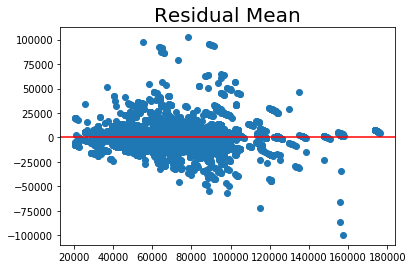

In [294]:
plt.scatter(y_pred_2, residuals_2)
plt.axhline(0, color='r')
plt.title('Residual Mean',size = 20)

In [329]:
def affluency_predictor(to_predict):
    
    # format the variable
    session_int = int(to_predict.strip())
    
    df = pd.read_csv("../Data/Z_cluster.csv")
    
    df = df[['zip_code',
             'cluster_0',
             'cluster_1',
             'cluster_2',
             'cluster_3',
             'cluster_4',
             'cluster_5',
             'cluster_6',
             'cluster_7',
             'cluster_8',
             'cluster_9',
             'cluster_10',
             'cluster_11',
             'cluster_12',
             'cluster_13',
             'cluster_14',
             'cluster_15',
             'cluster_16',
             'cluster_17',
             'cluster_18',
             'cluster_19',
             'cluster_20',
             'cluster_21',
             'cluster_22',
             'cluster_23',
             'cluster_24',
             'cluster_25',
             'cluster_26',
             'cluster_27',
             'cluster_28',
             'cluster_29',
             'cluster_30',
             'cluster_31',
             'cluster_32',
             'cluster_33',
             'cluster_34',
             'cluster_35',
             'cluster_36',
             'cluster_37',
             'cluster_38',
             'cluster_39',
             'cluster_40',
             'cluster_41',
             'cluster_42',
             'cluster_43',
             'cluster_44',
             'cluster_45',
             'cluster_46',
             'cluster_47',
             'cluster_48',
             'cluster_49',
             'cluster_50',
             'cluster_51',
             'cluster_52',
             'cluster_53',
             'cluster_54',
             'cluster_55',
             'cluster_56',
             'cluster_57',
             'cluster_58',
             'cluster_59',
             'cluster_60',
             'cluster_61',
             'cluster_62',
             'cluster_63',
             'cluster_64',
             'cluster_65',
             'cluster_66',
             'cluster_67',
             'cluster_68',
             'cluster_69',
             'cluster_70',
             'cluster_71',
             'cluster_72',
             'cluster_73',
             'cluster_74',
             'cluster_75',
             'cluster_76',
             'cluster_77',
             'cluster_78',
             'cluster_79',
             'cluster_80',
             'cluster_81',
             'cluster_82',
             'cluster_83',
             'cluster_84',
             'cluster_85',
             'cluster_86',
             'cluster_87',
             'cluster_88',
             'cluster_89',
             'cluster_90',
             'cluster_91',
             'cluster_92',
             'cluster_93',
             'cluster_94',
             'cluster_95',
             'cluster_96',
             'cluster_97',
             'cluster_98',
             'cluster_99',
             'cluster_100',
             'cluster_101',
             'cluster_102',
             'cluster_103',
             'cluster_104',
             'cluster_105',
             'cluster_106',
             'cluster_107',
             'cluster_108',
             'cluster_109',
             'cluster_110',
             'cluster_111',
             'cluster_112',
             'cluster_113',
             'cluster_114',
             'cluster_115',
             'cluster_116',
             'cluster_117',
             'cluster_118',
             'cluster_119',
             'cluster_120',
             'cluster_121',
             'cluster_122',
             'cluster_123',
             'cluster_124',
             'cluster_125',
             'cluster_126',
             'cluster_127',
             'cluster_128',
             'cluster_129',
             'cluster_130',
             'cluster_131',
             'cluster_132',
             'cluster_133',
             'cluster_134',
             'cluster_135',
             'cluster_136',
             'cluster_137',
             'cluster_138',
             'cluster_139',
             'cluster_140',
             'cluster_141',
             'cluster_142',
             'cluster_143',
             'cluster_144',
             'cluster_145',
             'cluster_146',
             'cluster_147',
             'cluster_148',
             'cluster_149',
             'cluster_150',
             'cluster_151',
             'cluster_152',
             'cluster_153',
             'cluster_154',
             'cluster_155',
             'cluster_156',
             'cluster_157',
             'cluster_158',
             'cluster_159',
             'cluster_160',
             'cluster_161',
             'cluster_162',
             'cluster_163',
             'cluster_164',
             'cluster_165',
             'cluster_166',
             'cluster_167',
             'cluster_168',
             'cluster_169',
             'cluster_170',
             'cluster_171',
             'cluster_172',
             'cluster_173',
             'cluster_174',
             'cluster_175',
             'cluster_176',
             'cluster_177',
             'cluster_178',
             'cluster_179',
             'cluster_180',
             'cluster_181',
             'cluster_182',
             'cluster_183',
             'cluster_184',
             'cluster_185',
             'cluster_186',
             'cluster_187',
             'cluster_188',
             'cluster_189',
             'cluster_190',
             'cluster_191',
             'cluster_192',
             'cluster_193',
             'cluster_194',
             'cluster_195',
             'cluster_196',
             'cluster_197',
             'cluster_198',
             'cluster_199',
             'cluster_200',
             'cluster_201',
             'cluster_202',
             'cluster_203',
             'cluster_204',
             'cluster_205',
             'cluster_206',
             'cluster_207',
             'cluster_208',
             'cluster_209',
             'cluster_210',
             'cluster_211',
             'cluster_212',
             'cluster_213',
             'cluster_214',
             'cluster_215',
             'cluster_216',
             'cluster_217',
             'cluster_218',
             'cluster_219',
             'cluster_220',
             'cluster_221',
             'cluster_222',
             'cluster_223',
             'cluster_224',
             'cluster_225',
             'cluster_226',
             'cluster_227',
             'cluster_228',
             'cluster_229',
             'cluster_230',
             'cluster_231',
             'cluster_232',
             'cluster_233',
             'cluster_234',
             'cluster_235',
             'cluster_236',
             'cluster_237',
             'cluster_238',
             'cluster_239',
             'cluster_240',
             'cluster_241',
             'cluster_242',
             'cluster_243',
             'cluster_244',
             'cluster_245',
             'cluster_246',
             'cluster_247',
             'cluster_248',
             'cluster_249',
             'cluster_250',
             'cluster_251',
             'cluster_252',
             'cluster_253',
             'cluster_254',
             'cluster_255',
             'cluster_256',
             'cluster_257',
             'cluster_258',
             'cluster_259',
             'cluster_260',
             'cluster_261',
             'cluster_262',
             'cluster_263',
             'cluster_264',
             'cluster_265',
             'cluster_266',
             'cluster_267',
             'cluster_268',
             'cluster_269',
             'cluster_270',
             'cluster_271',
             'cluster_272',
             'cluster_273',
             'cluster_274',
             'cluster_275',
             'cluster_276',
             'cluster_277',
             'cluster_278',
             'cluster_279',
             'cluster_280',
             'cluster_281',
             'cluster_282',
             'cluster_283',
             'cluster_284',
             'cluster_285',
             'cluster_286',
             'cluster_287',
             'cluster_288',
             'cluster_289',
             'cluster_290',
             'cluster_291',
             'cluster_292',
             'cluster_293',
             'cluster_294',
             'cluster_295',
             'cluster_296',
             'cluster_297',
             'cluster_298',
             'cluster_299',
             'price',
             'review_count',
             'rating',
             'price_adj']]
   
    # create array from dataframe row
    predict_array = Z_cluster.pivot_table(index='zip_code')[Z_cluster.pivot_table(index='zip_code').index == session_int].values
    print(predict_array)
    # load trained model
    loaded_model = pickle.load(open('../flask_app_complete/model_j.p','rb'))
    # predict
    result = loaded_model.predict(predict_array)
    print(result)
    print('------------')
    
    map_df = pd.read_csv('../data/data_zipcode_j.csv')
    la_coord = (34.0522, -118.2437)
    maps = folium.Map(location=la_coord, zoom_start=11)
    
    for each in map_df.iterrows():
        if int(each[1]['zip_code']) == session_int:
            popup_text = folium.Html(f""" 
                <strong>Zip Code: {each[1]["zip_code"].astype(int)}</strong> 
                </br>Med. IRS Income (Thousands): {each[1]["med_agi"].round(3)}
                </br>Predicted Income Thousands: {result[0].round(3)}
                </br>Avg. $ of Businesses: {each[1]["price"].round(3)}
                </br> Number of Businesses: {int(each[1]["count"])}""",
                script=True)
            
            popup = folium.Popup(popup_text, max_width=2650, show=True)

            coord = (each[1]['latitude'],each[1]['longitude'])
            
            maps = folium.Map(location=coord, zoom_start=13)
            
            
            folium.Marker(
                location = [each[1]['latitude'],each[1]['longitude']],
                popup=popup,
                clustered_marker = True).add_to(maps)
            
    

    return maps

In [331]:
affluency_predictor('90005')

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.44217687 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.   

In [125]:
# https://stackoverflow.com/questions/49735683/
df_2 = df_2.groupby('zip_code').filter(lambda x : len(x) > 1)

In [127]:
train, test = category_pricer(df_2, state=111)

/Users/Jelly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Jelly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Jelly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://p

In [128]:
train['zip_code'].dtype

dtype('O')

In [129]:
drop_columns = ['id', 'city', 'alias', 'med_agi', 'avg_agi', 'count']

X_train = train.drop(columns=drop_columns)
y_train = train['med_agi']

In [96]:
df_pivot = df_2.pivot_table(index=['zip_code'])
df_pivot['price*review_count'] = df_pivot['price']*df_pivot['review_count']
df_pivot

,avg_agi,count,latitude,longitude,med_agi,price,rating,review_count,price*review_count
zip_code,,,,,,,,,
90001,45650,92,33.976491,-118.248684,35660,1.282609,3.619565,49.956522,64.074669
90002,44463,21,33.954422,-118.245431,34000,1.095238,3.380952,27.904762,30.562358
90003,43342,71,33.972703,-118.271297,34397,1.197183,3.281690,35.915493,42.997421
90004,82091,155,34.075176,-118.305680,46581,1.529032,3.835484,240.883871,368.319209
90005,49310,147,34.059249,-118.300776,32461,1.639456,3.717687,358.448980,587.661252
...,...,...,...,...,...,...,...,...,...
93550,52134,96,34.574828,-118.096016,39279,1.312500,3.197917,76.635417,100.583984
93551,104279,113,34.603553,-118.157776,87628,1.539823,3.238938,143.681416,221.243950
93552,68924,32,34.566473,-118.050294,60612,1.125000,2.937500,73.531250,82.722656


In [62]:
X.shape

(309, 8)

In [63]:
y.shape

(309,)

In [43]:
train_pivot = train.pivot_table(index = ['zip_code'])
train_pivot['price*review_count'] = train_pivot['price']*df_pivot['review_count']
train_pivot.head()

,avg_agi,count,latitude,longitude,med_agi,price,price_adj,price_sc,rating,review_count,price*review_count
zip_code,,,,,,,,,,,
90001,45650,92,33.976229,-118.247777,35660,1.290323,-0.198745,-0.329821,3.620968,57.161290,64.460028
90002,44463,21,33.950147,-118.245240,34000,1.071429,-0.435365,-0.710292,3.392857,10.500000,29.897959
90003,43342,71,33.970692,-118.270369,34397,1.270833,-0.156673,-0.363697,3.270833,34.500000,45.642606
90004,82091,155,34.075116,-118.305675,46581,1.519231,-0.044908,0.068056,3.774038,239.903846,365.958189
90005,49310,147,34.059178,-118.301491,32461,1.612245,0.028259,0.229729,3.785714,333.142857,577.907539


In [97]:
lr = LinearRegression()

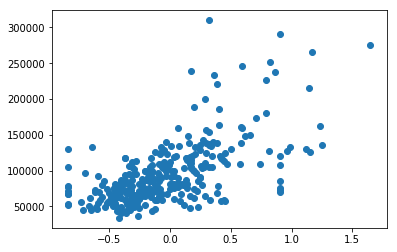

In [103]:
plt.scatter(x=train_pivot['price_sc'], y=train_pivot['avg_agi'])

In [105]:
lr.fit(train_pivot[['price_sc']], train_pivot['avg_agi'], sample_weight=train_pivot['count'])
print(lr.score(train_pivot[['price_sc']], train_pivot['avg_agi'], sample_weight=train_pivot['count']))

0.38914931899051275


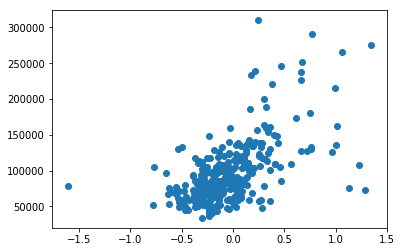

In [93]:
plt.scatter(x=train_pivot['price_adj'], y=train_pivot['avg_agi'])

In [106]:
lr.fit(train_pivot[['price_adj']], train_pivot['avg_agi'], sample_weight=train_pivot['count'])
print(lr.score(train_pivot[['price_adj']], train_pivot['avg_agi'], sample_weight=train_pivot['count']))

0.390333049778968


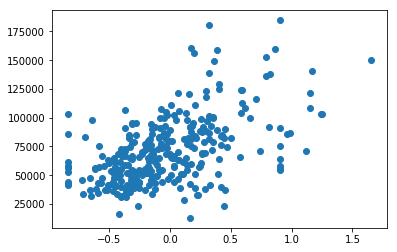

In [94]:
plt.scatter(x=train_pivot['price_sc'], y=train_pivot['med_agi'])

In [107]:
lr.fit(train_pivot[['price_sc']], train_pivot['med_agi'], sample_weight=train_pivot['count'])
print(lr.score(train_pivot[['price_sc']], train_pivot['med_agi'], sample_weight=train_pivot['count']))

0.2324496587469672


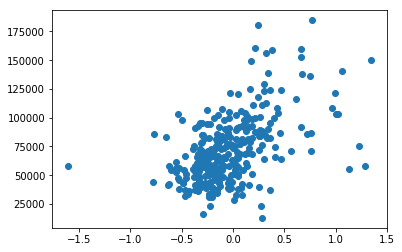

In [95]:
plt.scatter(x=train_pivot['price_adj'], y=train_pivot['med_agi'])

In [108]:
lr.fit(train_pivot[['price_adj']], train_pivot['med_agi'], sample_weight=train_pivot['count'])
print(lr.score(train_pivot[['price_adj']], train_pivot['med_agi'], sample_weight=train_pivot['count']))

0.24005956981553278


In [44]:
test_pivot = test.pivot_table(index = ['zip_code'])
test_pivot['price*review_count'] = test_pivot['price']*df_pivot['review_count']
test_pivot.head()

,avg_agi,count,latitude,longitude,med_agi,price,price_adj,price_sc,rating,review_count,price*review_count
zip_code,,,,,,,,,,,
90001,45650,92,33.977031,-118.250557,35660,1.266667,-0.145285,-0.370939,3.616667,35.066667,63.278261
90002,44463,21,33.962974,-118.245814,34000,1.142857,-0.325944,-0.586139,3.357143,62.714286,31.891156
90003,43342,71,33.976899,-118.273235,34397,1.043478,-0.610095,-0.758874,3.304348,38.869565,37.477036
90004,82091,155,34.075299,-118.305692,46581,1.549020,-0.054726,0.119834,3.960784,242.882353,373.133839
90005,49310,147,34.059392,-118.299345,32461,1.693878,0.187722,0.371619,3.581633,409.061224,607.168680


## trying different models

In [109]:
X_train = train_pivot.drop(columns=['avg_agi', 'latitude', 'longitude', 'med_agi'])
y_train_avg = train_pivot['avg_agi']
y_train_med = train_pivot['med_agi']

X_test = test_pivot.drop(columns=['avg_agi', 'latitude', 'longitude', 'med_agi'])
y_test_avg = test_pivot['avg_agi']
y_test_med = test_pivot['med_agi']

In [110]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train_med)

knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train_med)

cart_reg = DecisionTreeRegressor()
cart_reg.fit(X_train, y_train_med)

bagged_reg = BaggingRegressor()
bagged_reg.fit(X_train, y_train_med)

random_forest_reg = RandomForestRegressor()
random_forest_reg.fit(X_train, y_train_med)

adaboost_reg = AdaBoostRegressor()
adaboost_reg.fit(X_train, y_train_med)

support_vector_reg = SVR()
support_vector_reg.fit(X_train, y_train_med)

/Users/Jelly/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Jelly/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [113]:
def rmse_score(model, X_train, X_test, y_train, y_test):
    mse_train = mean_squared_error(y_true = y_train,
                                  y_pred = model.predict(X_train))
    mse_test = mean_squared_error(y_true = y_test,
                                  y_pred = model.predict(X_test))
    rmse_train = mse_train ** 0.5
    rmse_test = mse_test ** 0.5

    return (rmse_train, rmse_test)

In [114]:
rmse_score(linear_reg, X_train, X_test, y_train_med, y_test_med)

(22860.674551943524, 25090.113747688156)

In [115]:
print(linear_reg.score(X_train, y_train_med))
print(linear_reg.score(X_test, y_test_med))

0.37729231957812026
0.2499134109031923


## clustering

In [51]:
def get_coordinates(zipcode):
    '''
    Converts a five-digit USPS zip code to geographic coordinates.
    
    Arguments:
        zipcode:            a five-digit string or integer
        
    Returns:
        a tuple containing (longitude, latitude), in decimal degrees
    ''' 
    zipcode = str(zipcode)
    zip_coords = json.loads(open('../Assets/zip_code_coordinates.json').read())
    if len(zipcode) == 5 and zipcode.isnumeric():
        latitude = zip_coords[zipcode]['latitude']
        longitude = zip_coords[zipcode]['longitude']
        
    return longitude, latitude

In [91]:
transfer_tune_iterator(X, y, range(20, 50, 1))

0.26213049821210777
0.26241715814664146
0.3424006613172068
0.25290469850355835
0.3213993941939062
0.24722495270783829
0.3057509616520564
0.234165019167574
0.27170200041172177
0.30889186865337104
0.30623597264366686
0.2622286987024941
0.2616491222767985
0.27467569904282685
0.3307834212785634
0.23240152101492761
0.25377472924220157
0.28557398000931544
0.24503021940455516
0.26932825795542414
0.26961931098218683
0.24544284465725885
0.24795962605219404
0.2651319104722075
0.2601335860238586
0.20877528428049497
0.2783719871099296
0.2381248476600174
0.28421113164211564
0.30822492037915106


ValueError: If using all scalar values, you must pass an index

## median agi

In [46]:
X_train = train_pivot.drop(columns=['avg_agi','med_agi','latitude','longitude'])
#features = list(X.columns)
y_train = df_dummy['med_agi']

In [47]:
X_test = test_pivot.drop(columns=['avg_agi','med_agi','latitude','longitude'])
#features = list(X.columns)
y_test = df_dummy['med_agi']

In [ ]:
def pipeliner(transformer, estimator):
    
    # these dictionaries will allow us to pass string arguments in order to instantiate different objects
    trans_dict = {
        'cvect': CountVectorizer(),
        'tvect': TfidfVectorizer()
    }
    
    est_dict = {
        'mnb': MultinomialNB(),
        'logreg': LogisticRegression(solver='saga'),
        'rand': RandomForestClassifier(n_estimators=10),
        'extra': ExtraTreesClassifier(n_estimators=10)
    }
    
    # this is the actual pipeline object
    pipe = Pipeline([
        (transformer, eval(f'trans_dict["{transformer}"]')),
        ('dense', DenseTransformer()),
        (estimator, eval(f'est_dict["{estimator}"]'))
    ])
    
    return pipe

In [ ]:
def fit_grid_and_track(pipe, split, feature, params, twox, score_df):
    
    t = time.time()
    
    x_train, x_test, y_train, y_test = split
    
    # this condition allows us to calculate top features for the 0 class
    if not twox:
        y_train = 1 - y_train
        y_test = 1 - y_test
    
    # instantiate gridsearch.
    grid = GridSearchCV(pipe, params, cv=5, n_jobs=4)
    grid.fit(x_train[feature], y_train)
    
    best = grid.best_estimator_
    bestparams = grid.best_params_
    train_score = best.score(x_train[feature], y_train)
    test_score = best.score(x_test[feature], y_test)
    
    t = time.time() - t
    
    # only print out stats for the 1 class so we can see what's going on
    if twox:
        
        results = {}
        
        # store each results dictionary into our score DataFrame
        pipe_name = '-'.join([step for step in best.named_steps if step != 'dense'])
        results['pipeline'] = pipe_name
        results['feature'] = feature
        results['params'] = bestparams
        results['test'] = test_score
        results['overfit'] = train_score - test_score
        
        score_df = score_df.append(results, ignore_index=True)
        print(f'{pipe_name}: {feature}  -- {t}')
        print(f'train score: {train_score}')
        print(f'test score: {test_score}')
        print('--------------------------')
        print()
        
    return (best, score_df)

In [ ]:
# this function puts everything together. 
# still unsure if it's more clear like this or as one gigantic function.
# you can be the judge

def pipe_gridder(transformer, estimator, x, y, feature, params, scores):
    
    split = train_test_split(x, y, stratify=y, random_state=111)
    
    pipe = pipeliner(transformer, estimator)
    
    return fit_grid_and_track(pipe, split, feature, params, 1, scores)[1]

## change the data set from restaurant based to zipcode based

In [16]:
# df_pivot = df.pivot_table(index = ['zip_code'])
# df_pivot.head()

,avg_agi,count,latitude,longitude,med_agi,price,rating,review_count
zip_code,,,,,,,,
90001,45650,92,33.976491,-118.248684,35660,1.282609,3.619565,49.956522
90002,44463,21,33.954422,-118.245431,34000,1.095238,3.380952,27.904762
90003,43342,71,33.972703,-118.271297,34397,1.197183,3.281690,35.915493
90004,82091,155,34.075176,-118.305680,46581,1.529032,3.835484,240.883871
90005,49310,147,34.059249,-118.300776,32461,1.639456,3.717687,358.448980


##  Create New column for the combo of Price*review_count

In [18]:
# df_pivot['price*review_count'] = df_pivot['price']*df_pivot['review_count']

In [19]:
# df_pivot.head()

,avg_agi,count,latitude,longitude,med_agi,price,rating,review_count,price*review_count
zip_code,,,,,,,,,
90001,45650,92,33.976491,-118.248684,35660,1.282609,3.619565,49.956522,64.074669
90002,44463,21,33.954422,-118.245431,34000,1.095238,3.380952,27.904762,30.562358
90003,43342,71,33.972703,-118.271297,34397,1.197183,3.281690,35.915493,42.997421
90004,82091,155,34.075176,-118.305680,46581,1.529032,3.835484,240.883871,368.319209
90005,49310,147,34.059249,-118.300776,32461,1.639456,3.717687,358.448980,587.661252


## Breakdown the price from original Pivot table(average) to count how many we have for each price category

In [20]:
# count_price = (pd.crosstab(df["zip_code"], df['price']))
# count_price.columns = ['price_1','price_2','price_3','price_4']
# count_price.head()

,price_1,price_2,price_3,price_4
zip_code,,,,
90001,66,26,0,0
90002,19,2,0,0
90003,60,9,1,1
90004,77,74,4,0
90005,56,88,3,0


# Break Down for Rating column

In [21]:
# count_rating = (pd.crosstab(df["zip_code"], df['rating']))
# count_rating.columns = ['rating_0.0','rating_1.0','rating_1.5','rating_2.0','rating_2.5','rating_3.0','rating_3.5','rating_4.0','rating_4.5','rating_5']
# count_rating.head()

,rating_0.0,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5
zip_code,,,,,,,,,,
90001,0,0,4,8,9,9,14,19,17,12
90002,0,0,3,4,1,0,1,6,3,3
90003,0,2,7,10,7,7,8,11,10,9
90004,0,0,1,2,12,15,27,57,27,14
90005,0,1,2,5,5,19,26,58,30,1


## combine price and rating to zipcode file

In [22]:
# df_count = pd.merge(count_price, count_rating, left_on = 'zip_code', right_on = 'zip_code')
# df_count.head()

,price_1,price_2,price_3,price_4,rating_0.0,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5
zip_code,,,,,,,,,,,,,,
90001,66,26,0,0,0,0,4,8,9,9,14,19,17,12
90002,19,2,0,0,0,0,3,4,1,0,1,6,3,3
90003,60,9,1,1,0,2,7,10,7,7,8,11,10,9
90004,77,74,4,0,0,0,1,2,12,15,27,57,27,14
90005,56,88,3,0,0,1,2,5,5,19,26,58,30,1


In [23]:
# df_count.shape

(327, 14)

In [24]:
# df_pivot.shape

(327, 9)

## Below is the combined data for zipcode, price, and rating, without countvecrizer the catogory

In [25]:
# df_dummy = pd.merge(df_pivot, df_count, on="zip_code")
# df_dummy.drop(columns = ['price','rating'] ,inplace = True)
# df_dummy.reset_index(inplace = True)
# df_dummy.head()

,zip_code,avg_agi,count,latitude,longitude,med_agi,review_count,price*review_count,price_1,price_2,...,rating_0.0,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5
0,90001,45650,92,33.976491,-118.248684,35660,49.956522,64.074669,66,26,...,0,0,4,8,9,9,14,19,17,12
1,90002,44463,21,33.954422,-118.245431,34000,27.904762,30.562358,19,2,...,0,0,3,4,1,0,1,6,3,3
2,90003,43342,71,33.972703,-118.271297,34397,35.915493,42.997421,60,9,...,0,2,7,10,7,7,8,11,10,9
3,90004,82091,155,34.075176,-118.305680,46581,240.883871,368.319209,77,74,...,0,0,1,2,12,15,27,57,27,14
4,90005,49310,147,34.059249,-118.300776,32461,358.448980,587.661252,56,88,...,0,1,2,5,5,19,26,58,30,1


In [26]:
# df_dummy['zip_code'] = df_dummy['zip_code'].astype(str)

In [27]:
# df_dummy.dtypes

zip_code               object
avg_agi                 int64
count                   int64
latitude              float64
longitude             float64
med_agi                 int64
review_count          float64
price*review_count    float64
price_1                 int64
price_2                 int64
price_3                 int64
price_4                 int64
rating_0.0              int64
rating_1.0              int64
rating_1.5              int64
rating_2.0              int64
rating_2.5              int64
rating_3.0              int64
rating_3.5              int64
rating_4.0              int64
rating_4.5              int64
rating_5                int64
dtype: object

In [16]:
#df_dummy = df_dummy[df_dummy['count']>=50]

# Making the category a matrix via countvectrizor 

In [28]:
# cat_dict = df['category'].to_dict()

In [29]:
# for i in cat_dict:
#     cat_dict[i] = cat_dict[i].replace('[', '')
#     cat_dict[i] = cat_dict[i].replace(']', '')
#     cat_dict[i] = cat_dict[i].replace('\'', '')
#     cat_dict[i] = cat_dict[i].split(', ')

In [30]:
# df_cat = pd.DataFrame.from_dict(cat_dict, orient = 'index')
# df_cat.head()

,0,1,2,3,4
0,bbq,smokehouse,southern,None,None
1,sandwiches,None,None,None,None
2,juicebars,acaibowls,icecream,None,None
3,sandwiches,hotdogs,None,None,None
4,italian,None,None,None,None


In [31]:
# df_cat['zip_code'] = df['zip_code']
# df_cat

,0,1,2,3,4,zip_code
0,bbq,smokehouse,southern,None,None,92821
1,sandwiches,None,None,None,None,92821
2,juicebars,acaibowls,icecream,None,None,92821
3,sandwiches,hotdogs,None,None,None,92821
4,italian,None,None,None,None,92821
...,...,...,...,...,...,...
28107,foodtrucks,sandwiches,salad,None,None,92841
28108,foodtrucks,tacos,None,None,None,92841
28109,cheesesteaks,sandwiches,chicken_wings,None,None,92845
28110,mexican,None,None,None,None,91764


In [33]:
# # borrowwed from Erin Hwang 
# categories_df = df_cat.astype(str).groupby('zip_code').agg(lambda x: ' '.join(x.unique()))

In [34]:
# ##borrowwed from Erin Hwang
# categories_df['cat_text_by_zip'] = categories_df[0] + ' ' + categories_df[1] + ' ' + categories_df[2] + ' ' + categories_df[3] + ' ' + categories_df[4]
# categories_df.head()

,0,1,2,3,4,cat_text_by_zip
zip_code,,,,,,
90001,mexican foodtrucks burgers newamerican seafood...,None comfortfood sandwiches breakfast_brunch s...,None sandwiches catering bbq herbsandspices ch...,None,None,mexican foodtrucks burgers newamerican seafood...
90002,mexican pizza chicken_wings chinese sandwiches...,foodstands hotdogs None breakfast_brunch juice...,None desserts coffee foodstands chicken_wings ...,None,None,mexican pizza chicken_wings chinese sandwiches...
90003,breakfast_brunch grocery streetvendors mexican...,burgers bakeries mexican None breakfast_brunch...,mexican meats None burgers sandwiches coffee g...,None,None,breakfast_brunch grocery streetvendors mexican...
90004,coffee bbq filipino pizza korean gastropubs ba...,breakfast_brunch foodstands None kosher bbq ko...,cafes None salad german latin breakfast_brunch...,None,None,coffee bbq filipino pizza korean gastropubs ba...
90005,salvadoran bakeries bars bubbletea korean taco...,None korean shavedice bbq breakfast_brunch bub...,None asianfusion icecream tradamerican dessert...,None,None,salvadoran bakeries bars bubbletea korean taco...


In [35]:
# categories_df.loc['90001', 'cat_text_by_zip']

'mexican foodtrucks burgers newamerican seafood bars salvadoran thai hotdogs pizza chicken_wings sandwiches streetvendors icecream coffee localflavor sportsbars tacos bakeries chinese desserts seafoodmarkets grocery bbq donuts sushi latin chickenshop tex-mex None comfortfood sandwiches breakfast_brunch seafood foodtrucks streetvendors mexican hotdogs asianfusion customcakes tradamerican jewelry tacos juicebars meats gelato vietnamese latin chocolate burgers japanese chicken_wings brazilian bakeries catering southern cupcakes coffee foodstands vegan italian None sandwiches catering bbq herbsandspices chicken_wings food seafood hotdog chickenshop meats breakfast_brunch tradamerican customcakes comfortfood mexican diyfood None None'

In [24]:
# cvec = CountVectorizer()

In [25]:
# categories_df.reset_index(inplace = True)

In [26]:
# X = categories_df['cate_text_by_zip']
# y = categories_df['zip_code']

In [27]:
# df_cate = pd.DataFrame(cvec.fit_transform(X).toarray(),
#                 columns=cvec.get_feature_names() ) #
# df_cate.head()

,acaibowls,accessories,acupuncture,afghani,african,airportlounges,amusementparks,antiques,appliances,arabian,...,whiskeybars,wholesale_stores,wholesalers,wine_bars,wineries,winetasteclasses,winetastingroom,womenscloth,wraps,yoga
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## save the data with countvecrizer

In [28]:
# df = pd.concat([df_dummy, df_cate], axis=1, sort=False)
# df.head()

,zip_code,ave_agi,count,latitude,longitude,review_count,price*review_count,price_1,price_2,price_3,...,whiskeybars,wholesale_stores,wholesalers,wine_bars,wineries,winetasteclasses,winetastingroom,womenscloth,wraps,yoga
0,90001,25.152933,93,33.976603,-118.248763,49.483871,63.318071,67,26,0,...,0,0,0,0,0,0,0,0,0,0
1,90002,24.410496,21,33.954426,-118.245431,27.904762,30.562358,19,2,0,...,0,0,0,0,0,0,0,0,0,0
2,90003,23.404622,71,33.972703,-118.271297,35.929577,43.014283,60,9,1,...,0,0,0,0,0,0,0,0,0,0
3,90004,59.128947,155,34.075176,-118.305680,240.987097,368.477045,77,74,4,...,0,0,0,0,0,0,0,0,0,0
4,90005,45.821128,147,34.059249,-118.300776,358.482993,587.717016,56,88,3,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# df.to_csv('../data/data_cv.csv')

In [30]:
#count_price_rating = (pd.crosstab(df["zip_code"], df['price*rating']))
#count_price_rating.head()

In [31]:
#numeric_data = df._get_numeric_data().columns

## Begin to Model

## Tried both data with vecorizer and without, turns out the data without vectorizer performs better, so I will stick with this one

## Jerry's way to countvectorizer

In [35]:
#df_dummy

In [36]:
#category_pricer(X,y,state=42)

In [37]:
# numeric_data = df_dummy._get_numeric_data().columns
# X = df_dummy._get_numeric_data().drop(columns=['ave_agi','latitude','longitude'])
# features = list(X.columns)
# y = df_dummy['ave_agi']
# poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
# X_poly = poly.fit_transform(X)
# X_poly_train,X_poly_test,y_train,y_test = train_test_split(X_poly,y, random_state = 42)
# ss=StandardScaler()
# ss.fit(X_poly_train)
# X_train_sc=ss.transform(X_poly_train)
# X_test_sc = ss.transform(X_poly_test)
# lm = LinearRegression()
# lm.fit(X_train_sc, y_train)
# l_alpha = np.logspace(-1, 2, 100)
# lasso = LassoCV(alphas=l_alpha, cv=5, max_iter=1000)
# lasso.fit(X_train_sc, y_train)


In [38]:
#lm.score(X_test_sc,y_test)

In [39]:
#lasso.alpha_

In [40]:
#lasso.score(X_test_sc, y_test)

In [41]:
# coef_df = pd.DataFrame({"Predictor Variables":poly.get_feature_names(features),"Coef_weight":lasso.coef_,'absolute':abs(lasso.coef_)})
# coef_df.sort_values(by='absolute',ascending = False).head(20)

In [42]:
#df_dummy['price*rating*price_3']=df_dummy['price*rating']*df_dummy['price_3']

In [43]:
#df_dummy['price*review_count^2']=df_dummy['price*review_count']**2

In [44]:
X = df_dummy.drop(columns=['ave_agi','latitude','longitude'])
#features = list(X.columns)
y = df_dummy['ave_agi']

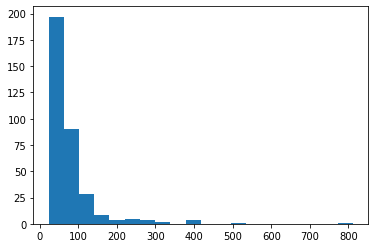

In [45]:
plt.hist(df["ave_agi"], bins=20);

In [46]:
y = np.log(df_dummy["ave_agi"])  #y = np.log(df.copy()["ave_agi"])

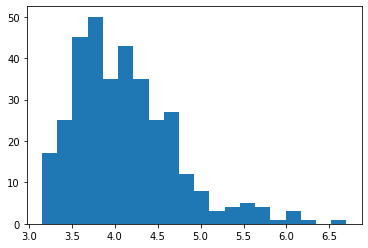

In [47]:
plt.hist(y, bins=20);

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X.copy(), y.copy(), random_state=42, test_size=0.3
)

In [49]:
# sc = StandardScaler()  did not have significant impact
# X_train = sc.fit_transform(X_train)
# X_test =sc.transform(X_test)

# Trying different models
 - linear regression
 - knn regression
 - decision tree
 - bagging
 - random_forest
 - ada boost
 - support_vector

In [50]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train)

cart_reg = DecisionTreeRegressor()
cart_reg.fit(X_train, y_train)

bagged_reg = BaggingRegressor()
bagged_reg.fit(X_train, y_train)

random_forest_reg = RandomForestRegressor()
random_forest_reg.fit(X_train, y_train)

adaboost_reg = AdaBoostRegressor()
adaboost_reg.fit(X_train, y_train)

support_vector_reg = SVR()
support_vector_reg.fit(X_train, y_train)

C:\Users\m6zha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\m6zha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

# Evaluate our models

In [51]:
def rmse_score(model, X_train, X_test, y_train, y_test):
    mse_train = mean_squared_error(y_true = y_train,
                                  y_pred = model.predict(X_train))
    mse_test = mean_squared_error(y_true = y_test,
                                  y_pred = model.predict(X_test))
    rmse_train = mse_train ** 0.5
    rmse_test = mse_test ** 0.5
    
    print("The training RMSE for " + str(model) + " is: " + str(rmse_train))
    print("The testing RMSE for " + str(model) + " is: " + str(rmse_test))
    return (rmse_train, rmse_test)

## Evaluate linear regression

In [52]:
rmse_score(linear_reg, X_train, X_test, y_train, y_test)

The training RMSE for LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) is: 0.41406032648009605
The testing RMSE for LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) is: 0.4427913535045525


(0.41406032648009605, 0.4427913535045525)

In [53]:
print(linear_reg.score(X_train, y_train))
print (linear_reg.score(X_test, y_test))

0.5147910293292067
0.47839914958496865


## Evaluate Knn

In [54]:
rmse_score(knn_reg, X_train, X_test, y_train, y_test)

The training RMSE for KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform') is: 0.39318306989645424
The testing RMSE for KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform') is: 0.5096064893881826


(0.39318306989645424, 0.5096064893881826)

In [55]:
print(knn_reg.score(X_train, y_train))
print (knn_reg.score(X_test, y_test))

0.5624867605056363
0.30910837720559015


## Evaluate decision tree

In [56]:
rmse_score(cart_reg, X_train, X_test, y_train, y_test)

The training RMSE for DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best') is: 8.108321509524573e-06
The testing RMSE for DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best') is: 0.5444330748167281


(8.108321509524573e-06, 0.5444330748167281)

In [57]:
print(cart_reg.score(X_train, y_train))
print (cart_reg.score(X_test, y_test))

0.9999999998139355
0.21145037485715332


## Evaluate Bagging model

In [58]:
rmse_score(bagged_reg, X_train, X_test, y_train, y_test)

The training RMSE for BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False) is: 0.17780679577795952
The testing RMSE for BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False) is: 0.43827305281902673


(0.17780679577795952, 0.43827305281902673)

In [59]:
print(bagged_reg.score(X_train, y_train))
print (bagged_reg.score(X_test, y_test))

0.9105257034670327
0.4889898044024327


## Evaluate random forest

In [60]:
rmse_score(random_forest_reg, X_train, X_test, y_train, y_test)

The training RMSE for RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False) is: 0.20272083278022346
The testing RMSE for RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False) is: 0.4

(0.20272083278022346, 0.43284511969031675)

In [61]:
print(random_forest_reg.score(X_train, y_train))
print (random_forest_reg.score(X_test, y_test))

0.8836950110322918
0.5015689629110164


## Evaluate adaboost

In [62]:
rmse_score(adaboost_reg, X_train, X_test, y_train, y_test)

The training RMSE for AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None) is: 0.30354282546676403
The testing RMSE for AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None) is: 0.4189407949700068


(0.30354282546676403, 0.4189407949700068)

In [63]:
print(adaboost_reg.score(X_train, y_train))
print (adaboost_reg.score(X_test, y_test))

0.7392396676609552
0.5330769300069924


## Evaluate Support vector regression

In [64]:
rmse_score(support_vector_reg, X_train, X_test, y_train, y_test)

The training RMSE for SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False) is: 0.16770974888612417
The testing RMSE for SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False) is: 0.6186804524967324


(0.16770974888612417, 0.6186804524967324)

In [65]:
print(support_vector_reg.score(X_train, y_train))
print (support_vector_reg.score(X_test, y_test))

0.9203990595978905
-0.018293136061588777


## Test Model with pipelines

In [66]:
pipe = Pipeline([
    ('linear', LinearRegression())
])

pipe_params = {
                 'linear__fit_intercept': [True,False], 
                 'linear__normalize': [True, False],
                 'linear__copy_X': [True, False],
                 'linear__n_jobs': [1,5,10]
}

pipe_gridsearch = GridSearchCV(pipe, 
                                 pipe_params, 
                                 cv=5, 
                                 verbose=1)
pipe_gridsearch.fit(X_train, y_train);
print(pipe_gridsearch.best_score_)
pipe_gridsearch.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.42632103866065996


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.8s finished


Pipeline(memory=None,
         steps=[('linear',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1,
                                  normalize=False))],
         verbose=False)

In [67]:
knn_params = {
    'n_neighbors': range(1, 51, 10),
    'metric': ['euclidean', 'manhattan']
}
knn_gridsearch = GridSearchCV(KNeighborsRegressor(), 
                              knn_params, 
                              cv=5, 
                              verbose=1)
knn_gridsearch.fit(X_train, y_train);
best_knn = knn_gridsearch.best_estimator_
best_knn.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished


0.3363456986617267

In [68]:
cart_params = {
    'max_depth': [15,25,50]
    
}
cart_gridsearch = GridSearchCV(DecisionTreeRegressor(), 
                              cart_params, 
                              cv=5, 
                              verbose=1)
cart_gridsearch.fit(X_train, y_train);
best_cart = cart_gridsearch.best_estimator_
best_cart.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.0s finished


0.06901997368182344

In [69]:
BaggingRegressor()

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [70]:
bag_params = {
    'n_estimators': [120,140,160],
    
    
}
bag_gridsearch = GridSearchCV(BaggingRegressor(),
                              bag_params,
                              cv=5, 
                              verbose=1)
bag_gridsearch.fit(X_train, y_train);
best_bag = bag_gridsearch.best_estimator_
print (best_bag)
best_bag.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    8.7s finished


BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=120,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)


0.5413432111396294

In [71]:
rf_params = {
    'n_estimators': [100,110,120],
    'max_depth':[6,7,8,9]
    
    
}
rf_gridsearch = GridSearchCV(RandomForestRegressor(), 
                              rf_params,
                              cv=5, 
                              verbose=1)
rf_gridsearch.fit(X_train, y_train);
best_rf = rf_gridsearch.best_estimator_
print (best_rf)
best_rf.score(X_test, y_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   22.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


0.5155424036993277

In [72]:
AdaBoostRegressor()

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [73]:
ada_params = {
    'n_estimators': [75,85,90]
}
ada_gridsearch = GridSearchCV(AdaBoostRegressor(), 
                              ada_params, 
                              cv=5, 
                              verbose=1)
ada_gridsearch.fit(X_train, y_train);
best_ada = ada_gridsearch.best_estimator_
print (best_ada)
best_ada.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.9s finished


AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=90, random_state=None)


0.5565837490866395

In [74]:
svr_params = {
    'degree': [2,3]
}
svr_gridsearch = GridSearchCV(SVR(), 
                              svr_params, 
                              cv=5, 
                              verbose=1)
svr_gridsearch.fit(X_train, y_train);
best_svr = svr_gridsearch.best_estimator_
print (best_svr)
best_svr.score(X_test, y_test)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
SVR(C=1.0, cache_size=200, coef0=0.0, degree=2, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\m6zha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\m6zha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\m6zha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning

-0.018293136061588777

|model|RMSE Train|RMSE Test|R2 Train|R2 Test|pipeline R2 test|
| --- | --- | --- | --- | ---|---|
|Linear Regression| 0.414|0.44|0.54|0.56|0.43|
|KNN Regression| 0.39|0.51|0.56|0.31|0.33|
|Decision Tree Regression| 8.11e05|0.56|0.99|0.16|0.03|
|Baggin Regression| 0.19|0.46|0.89|0.45|0.54|
|Random Forest Regression| 0.17|0.42|0.92|0.53|0.536|
|Adaboost Regression| 0.29|0.42|0.77|0.53|0.543|
|support vector Regression| 0.17|0.62|0.92|-0.02|-0.02|

# Using KMean Cluster to group Zipcodes

In [75]:
def transfer_tune(X, y, k):
    location_data = df_dummy[["latitude", "longitude"]]
    km = KMeans(n_clusters=k,random_state = 42 )
    km.fit(location_data)
    X.loc[:, "cluster"] = km.predict(location_data)
    X_dummy = pd.get_dummies(columns=["cluster"], data=X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.3
    )
    adaboost_reg.fit(X_train, y_train)
    r2 =adaboost_reg.score(X_test, y_test)
    print(f"{k} : {r2}")

In [76]:
for k in range(20, 50, 1):
    transfer_tune(X, y, k)

20 : 0.5835060317397737
21 : 0.5471030430223478
22 : 0.581964849904541
23 : 0.5828688723731565
24 : 0.5721730905872096
25 : 0.5498509069205426
26 : 0.5559880481379316
27 : 0.5463292152779873
28 : 0.6208236783593478
29 : 0.5553792624178007
30 : 0.5355150830767403
31 : 0.5455963200773923
32 : 0.5329299896548393
33 : 0.5070166661213327
34 : 0.5508114000767257
35 : 0.5633730016668823
36 : 0.5194989933278629
37 : 0.5933771629007382
38 : 0.49036068196187743
39 : 0.6051803639160475
40 : 0.5501857877942082
41 : 0.5776462569407903
42 : 0.5789594355983094
43 : 0.53136199695815
44 : 0.543899242461797
45 : 0.5150263965146414
46 : 0.5493354309049456
47 : 0.5827454827539178
48 : 0.5437524123568125
49 : 0.5463120668194232


In [77]:
location_data = df_dummy[["latitude", "longitude"]]
km = KMeans(n_clusters=39, random_state = 42)
km.fit(location_data)
X.loc[:, "cluster"] = km.predict(location_data)
X_dummy = pd.get_dummies(columns=["cluster"], data=X)
X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.3
)

adaboost_reg.fit(X_train, y_train)
r2 = adaboost_reg.score(X_test, y_test)
print (r2)

0.6249724470192086


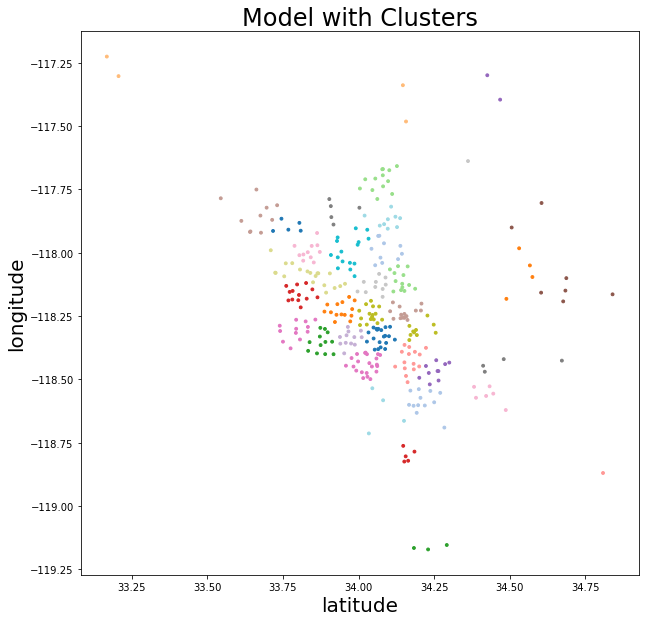

In [78]:
plt.figure(figsize=(10, 10))
plt.scatter(df_dummy.latitude, df_dummy.longitude, c=km.labels_, s=8, cmap="tab20")
plt.xlabel("latitude", fontsize = 20)
plt.ylabel("longitude", fontsize = 20)
plt.title('Model with Clusters', fontsize = 24);

In [79]:
X_cluster = pd.concat([X_train,X_test],axis = 0, sort = False)

In [80]:
X_cluster.to_csv('../data/X_cluster.csv')

In [81]:
y_pred = adaboost_reg.predict(X_test)

In [82]:
y_pred

array([3.97186296, 4.01499049, 4.53161682, 4.14599518, 3.88529275,
       3.76264027, 3.88529275, 3.88479546, 3.83216966, 3.75943497,
       4.23572119, 4.85656826, 4.06978073, 4.23572119, 3.98025267,
       5.28073393, 4.18661128, 3.97674343, 3.74926785, 3.95126167,
       4.2583482 , 4.16884838, 4.09619278, 3.50507554, 3.79118434,
       4.71675609, 4.09262689, 4.35090928, 4.1683494 , 4.09262689,
       5.33733534, 3.97856611, 3.97674343, 4.14136539, 4.04455282,
       4.19179511, 4.05956733, 3.97186296, 3.97674343, 5.48303764,
       3.9919906 , 3.88479546, 3.98878082, 3.6802383 , 4.65220769,
       4.56743288, 4.05653157, 4.53161682, 5.52402818, 3.97856611,
       3.92790072, 3.74926785, 3.83781463, 4.07588648, 3.55730907,
       3.7767588 , 3.62874817, 4.1499051 , 4.09262689, 4.36338867,
       3.98878082, 4.19179511, 4.01740432, 4.62014007, 3.88479546,
       4.69772623, 3.97186296, 4.45270934, 3.76264027, 3.52999176,
       3.98612393, 3.60638693, 4.35090928, 4.1499051 , 3.92816

In [86]:
df_dummy['pred']=adaboost_reg.predict(X_cluster)

In [90]:
df_dummy[df_dummy['zip_code']=='90015']

,zip_code,ave_agi,count,latitude,longitude,review_count,price*review_count,price_1,price_2,price_3,...,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5,pred
13,90015,58.668145,219,34.040507,-118.262166,221.292237,353.663393,107,96,13,...,3,2,6,10,32,46,59,47,14,3.76264


In [91]:
residuals = y_test - y_pred

In [92]:
residuals.sort_values()

5     -0.761799
179   -0.652460
3     -0.572487
145   -0.526350
148   -0.514022
         ...   
318    0.845949
101    0.855785
63     0.944958
84     1.007050
57     1.361650
Name: ave_agi, Length: 104, dtype: float64

Text(0.5, 1.0, 'Residual Mean')

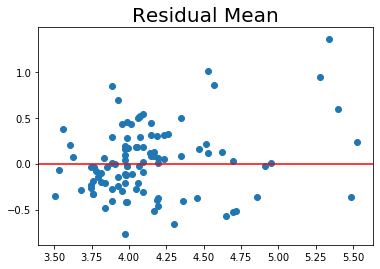

In [93]:
plt.scatter(y_pred, residuals)
plt.axhline(0, color='r')
plt.title('Residual Mean',size = 20)
#plt.savefig('./plots/residual.png')

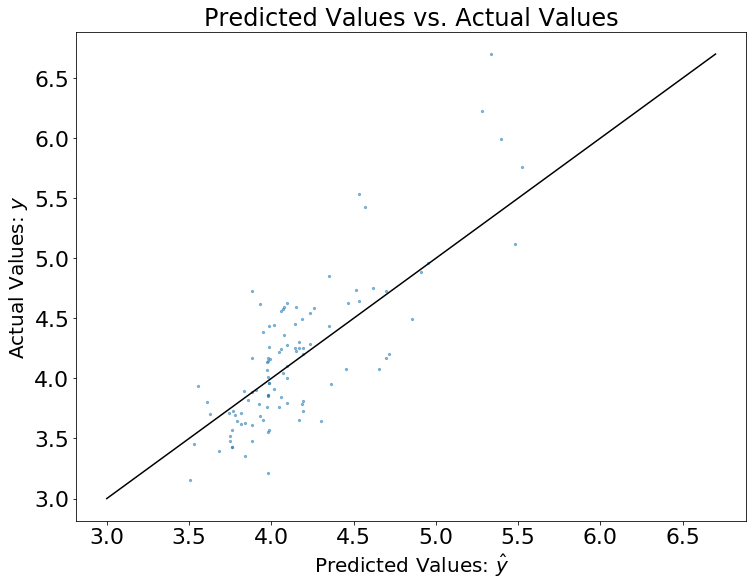

In [94]:

plt.figure(figsize=(12,9))
plt.rc('font', size=22)
# Generate a scatterplot of predicted values versus actual values.
plt.scatter(y_pred, y_test, s=5, alpha = 0.5)

# Plot a line.
plt.plot([3, np.max(y_test)],
         [3, np.max(y_test)],
         color = 'black')

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Predicted Values vs. Actual Values', fontsize = 24);

In [95]:
pickle.dump(linear_reg, open('../flask_app_complete/model.p', 'wb'))